In [4]:
import typing as tp

import torch
import torch_geometric
from torch_geometric.data import download_url, extract_zip

print('torch', torch.__version__)
print('torch_geometric', torch_geometric.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You are using device: {device}\n")

# url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
# extract_zip(download_url(url, '.'), '.')

dataset = 'ml-latest-small'
movie_path = f'./{dataset}/movies.csv'
rating_path = f'./{dataset}/ratings.csv'

torch 1.9.0
torch_geometric 2.0.2
You are using device: cuda



# Explore data

In [5]:
import pandas as pd

movies = pd.read_csv(movie_path)
ratings = pd.read_csv(rating_path)
print(movies.head())
print(ratings.head())

genres = set(g for gs in movies.genres for g in gs.strip().split('|'))
print('\n', genres, len(genres))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

 {'Sci-Fi', 'Adventure', 'Documentary', 'Crime', 'Children', 'Film-Noir', 'IMAX', 'Fantasy', 'Thriller', '(no genres listed)', 'Horror', 'Romance', 'Action', 'War', 'Animation'

# Load Node and Edge

In [6]:
import torch

def load_node_csv(path, index_col, encoders: tp.Optional[tp.Dict] = None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [7]:
from sentence_transformers import SentenceTransformer

class SequenceEncoder:
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(
            df.values, 
            show_progress_bar=True,
            convert_to_tensor=True, 
            device=self.device,
        )
        return x


In [8]:
class GenresEncoder(object):
    def __init__(self, sep='|', device=None):
        self.sep = sep
        self.device = device

    def __call__(self, sr: pd.Series):
        genres = set(g for col in sr.values for g in col.split(self.sep))
        mapping = {genre: i for i, genre in enumerate(genres)}

        x = torch.zeros(len(sr), len(mapping)).to(self.device)
        for i, col in enumerate(sr.values):
            for genre in col.split(self.sep):
                x[i, mapping[genre]] = 1
        return x


In [9]:
movie_x, movie_mapping = load_node_csv(
    movie_path, index_col='movieId', encoders={
        'title': SequenceEncoder(),
        'genres': GenresEncoder(device=device)
    })
_, user_mapping = load_node_csv(rating_path, index_col='userId')

Batches: 100%|██████████| 305/305 [00:03<00:00, 96.28it/s] 


In [10]:
from torch_geometric.data import HeteroData

data = HeteroData()

data['user'].num_nodes = len(user_mapping)  # Users do not have any features.
data['movie'].x = movie_x

print(data)

HeteroData(
  user={ num_nodes=610 },
  movie={ x=[9742, 404] }
)


In [11]:
def load_edge_csv(
    path, 
    src_index_col, src_mapping, 
    dst_index_col, dst_mapping,
    encoders: tp.Optional[tp.Dict] = None, 
    **kwargs,
):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[s] for s in df[src_index_col]]
    dst = [dst_mapping[d] for d in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr


In [12]:
class IdentityEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)


In [13]:
edge_index, edge_label = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    encoders={'rating': IdentityEncoder(dtype=torch.long)},
)

data['user', 'rates', 'movie'].edge_index = edge_index
data['user', 'rates', 'movie'].edge_label = edge_label

print(data)
print(data.is_undirected())

HeteroData(
  user={ num_nodes=610 },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836, 1]
  }
)
False


In [14]:
src = [user_mapping[s] for s in ratings['userId']]
dst = [movie_mapping[d] for d in ratings['movieId']]
edges = torch.tensor([src, dst])

print(type(edges), edges.shape)
print(len(ratings))

<class 'torch.Tensor'> torch.Size([2, 100836])
100836


In [15]:

from torch_geometric.transforms import ToUndirected, RandomLinkSplit

# 1. Add a reverse ('movie', 'rev_rates', 'user') relation for message passing.
data = ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# 2. Perform a link-level split into training, validation, and test edges.
transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

HeteroData(
  user={ num_nodes=610 },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 85712],
    edge_label=[85712, 1],
    edge_label_index=[2, 85712]
  },
  (movie, rev_rates, user)={ edge_index=[2, 85712] }
)
HeteroData(
  user={ num_nodes=610 },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 85712],
    edge_label=[5041, 1],
    edge_label_index=[2, 5041]
  },
  (movie, rev_rates, user)={ edge_index=[2, 85712] }
)
HeteroData(
  user={ num_nodes=610 },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 90753],
    edge_label=[10083, 1],
    edge_label_index=[2, 10083]
  },
  (movie, rev_rates, user)={ edge_index=[2, 90753] }
)


In [16]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [28]:
# import torch.nn.functional as F

# model = GNN(128, label_len)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data.x_dict, data.edge_index_dict)
#     mask = data['paper'].train_mask
#     loss = F.cross_entropy(out['paper'][mask], data['paper'].y[mask])
#     loss.backward()
#     optimizer.step()
    
#     return float(loss)

NameError: name 'model' is not defined

In [27]:
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embed = torch.nn.Embedding(num_nodes, 16)
        self.conv1 = GCNConv(16, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc1 = torch.nn.Linear(32, 1)

    def encode(self):
        x = self.embed(data.x)
        x = x.squeeze()
        x = self.conv1(x, data.edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.edge_index) # convolution 2

    def decode(self, z): 
        z = torch.concat((z[data.edge_index[0]], z[data.edge_index[1]]), axis=-1)
        return self.fc1(z)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

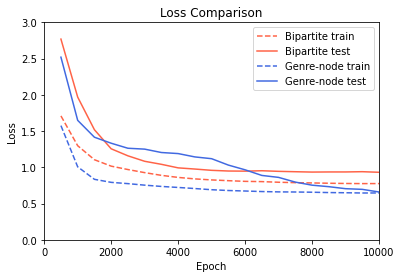

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

result = Path('./results')

def load_df(fp):
    df = pd.read_csv(result / fp, sep='\t', comment='#')
    df = df.set_index('idx', drop=False)
    return df

def plot_df(plt_, df, name, color):
    plt_.plot(df['Train_Err'], label=f'{name} train', linestyle='dashed', color=color)
    plt_.plot(df['Test_Err'], label=f'{name} test', color=color)

def make_plot(dfs, title='', r_lim=13_000, top=3.):
    # plt.figure(figsize=(12, 4))
    plt.title(title)
    plt.ylim(top=top)
    plt.xlim(right=r_lim)

    colors = ['tomato', 'royalblue', 'yellowgreen', 'mediumorchid']
    for color, (name, df) in zip(colors, dfs.items()):
        plot_df(plt, df, name, color)

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

make_plot(
    dfs={
        'Bipartite': load_df('gcn-base.tsv'),
        'Genre-node': load_df('gcn-genre.tsv'),
    },
    title='Loss Comparison',
    r_lim=10_000,
)

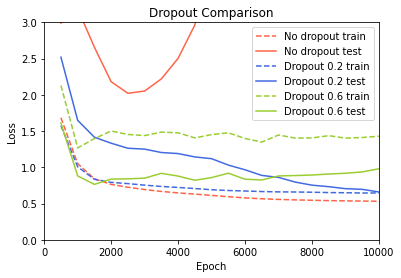

In [55]:
make_plot(
    dfs={
        'No dropout': load_df('gcn-genre-no-dropout.tsv'),
        'Dropout 0.2': load_df('gcn-genre.tsv'),
        'Dropout 0.6': load_df('gcn-genre-dropout06.tsv'),
    },
    title='Dropout Comparison',
    r_lim=10_000,
)

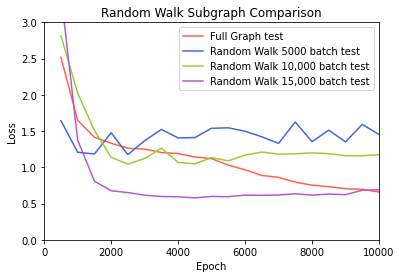

In [76]:
def make_plot_2(dfs, title='', r_lim=13_000, top=3.):
    
    def plot_df(plt_, df, name, color):
        # plt_.plot(df['Train_Err'], label=f'{name} train', linestyle='dashed', color=color)
        plt_.plot(df['Test_Err'], label=f'{name} test', color=color)

    plt.title(title)
    plt.ylim(top=top)
    plt.xlim(right=r_lim)

    colors = ['tomato', 'royalblue', 'yellowgreen', 'mediumorchid', 'olive']
    for color, (name, df) in zip(colors, dfs.items()):
        plot_df(plt, df, name, color)

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

make_plot_2(
    dfs={
        'Full Graph': load_df('gcn-genre.tsv'),
        'Random Walk 5000 batch': load_df('gcn-genre-randwalk.tsv'),
        'Random Walk 10,000 batch': load_df('gcn-genre-randwalk-10k.tsv'),
        'Random Walk 15,000 batch': load_df('gcn-genre-randwalk-15k.tsv'),
    },
    title='Random Walk Subgraph Comparison',
    r_lim=10_000,
)

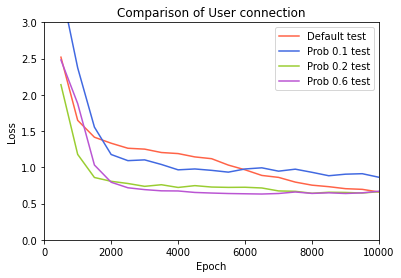

In [79]:
make_plot_2(
    dfs={
        'Default': load_df('gcn-genre.tsv'),
        'Prob 0.1': load_df('gcn-genre-extra01.tsv'),
        'Prob 0.2': load_df('gcn-genre-extra02.tsv'),
        # 'Prob 0.4': load_df('gcn-genre-extra04.tsv'),
        'Prob 0.6': load_df('gcn-genre-extra06.tsv'),
    },
    title='Comparison of User connection',
    r_lim=10_000,
)

## Experiment & Results

How did you measure success? What experiments were used? What were the results, both quantitative and qualitative? Did you succeed? Did you fail? Why?

Our experiment is conducted on the MovieLens small dataset, with 10,372 nodes and 100,836 ratings. The dataset is split into  70% train, 10% validation, and 20% test with our custom method such that only the `ratings` edges are split in each set, and all the nodes and other type of edge stayed the dataset. This setup is to support our experiment on different way to model our data.

### User-Movie vs User-Movie-Genre
 
Even though the objective is the provide one of the 10 labels: 0.0-5.0, we treat this problem as regression. From our team's past experience, solving the regresion problem, with the MSE as our loss function, will give better loss gradient than classifier score. 

For our implementation, we use homogeneous graph, treating all nodes as same type with same size of embedding. There are two modeling that we try in this project: treating the recommender system as bipartite graph of User->Movie, and treating Genres as separate entity: User->Movies->Genres. 

(Plot)

In this experiment, the result matches our intuition on the problem. The bipartite graph is able to extract some relevant information from Movie's embed, and propagates that to Users. However, it falls short, comparing explicit modeling Genres as separate kind of node. The bipartite graph only reflects the correlation between Users' rating and their Movie, so the Movie's embedding most likely represent the rating. By treating Genre as separate kind of node, we bring in a new set of features to help connecting Users' preference. This reflects on better predicting score.

### Dropout

Dropout also shows to reduce overfitting on our model:

(Plot)

With no dropout, it clearly shows the overfitting, where test result gets worse while training result is getting better. And with high dropout (ex: 0.6), the model loses too much information from the data.

### Subgraph



